# SBD on nuclear shell model

In [45]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.utils_quasiparticle_approximation import HardcoreBosonsBasis
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.fermi_hubbard_library import FemionicBasis
import numpy as np
from typing import List, Dict
from scipy.linalg import expm
import scipy
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import minimize
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
from scipy.optimize import minimize
from scipy import sparse
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
import torch
import torch.nn as nn
import torch.optim as optim


file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

In [46]:
nparticles_a=8
nparticles_b=2 # Berillium

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

Exact solution:

In [47]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

####
H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
basis = NSMHamiltonian.basis # basis
###

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1) # exact solution, later to confront
psi0 = psi0.reshape(-1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-87.14199175]
total_m= 3.7172729104524614e-17
dimension= 4206


Hartree-Fock

Load the two-body matrix

In [4]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:42<00:00,  1.77s/it]


In [48]:

#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -53.230630
Step   20 | Energy = -60.849847
Step   40 | Energy = -65.726586
Step   60 | Energy = -69.139942
Step   80 | Energy = -71.683119
Step  100 | Energy = -73.695386
Step  120 | Energy = -75.237942
Step  140 | Energy = -76.428608
Step  160 | Energy = -77.459182
Step  180 | Energy = -78.346223
Step  200 | Energy = -78.974283
Step  220 | Energy = -79.393991
Step  240 | Energy = -79.731829
Step  260 | Energy = -80.015873
Step  280 | Energy = -80.242565
Step  300 | Energy = -80.410467
Step  320 | Energy = -80.527472
Step  340 | Energy = -80.606424
Step  360 | Energy = -80.659304
Step  380 | Energy = -80.695014
Step  400 | Energy = -80.719526
Step  420 | Energy = -80.736669
Step  440 | Energy = -80.748864
Step  460 | Energy = -80.757655
Step  480 | Energy = -80.764057
Step  500 | Energy = -80.768757
Step  520 | Energy = -80.772231
Step  540 | Energy = -80.774816
Step  560 | Energy = -80.776751
Step  580 | Energy = -80.778207
Step  599 | Energy = -80.779261


In [49]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p


    return psi  # [F]

def slater_determinants_only_neutrons(C_n, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]


    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()


        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]




        det_n = torch.det(Cn_sub)

        psi[i] = det_n 

    return psi  # [F]


In [50]:

#psi_hf=slater_determinants_only_neutrons(model.C_n, torch.tensor(NSMHamiltonian.basis))
psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)

In [51]:


print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)
print(psi_hf.shape)
print('fidelity=',psi0[:].conjugate().dot(psi_hf)*np.conjugate(psi0[:].conjugate().dot(psi_hf)))

-82.2297983134683
(4206,)
fidelity= 0.43238019692938434


Voglio una classe Nuclear shell model sqd ansatz (trova un nome migliore hahah), i suoi parametri sono H e la base oppure numero particelle e per il resto fa automatico. Voglio i seguenti metodi:
- Inizializzazione stato con lo stato della base con minore energia
- Creazione operator pool
- compute state con produttoria delle unitarie ottenute esponenziando la somma degli operatori nell'operator pool sommati con il loro complesso coniugato fatta con scipy exp multiply applicato a stato precedente (se prima iter a quello dell'inizializzazione)
- fare SQD con quello stato e stimare energia con SQD

In secondo momento sarà da aggiungere anche minimizzazione energia!!!


In [ ]:
import itertools
from scipy.optimize import dual_annealing
from typing import Optional




class NSM_SQD_circuit_ansatz:

    def __init__(self,twobody_matrix:Dict, NSMHamiltonian, samples = 20, batches =100, train_steps = 10,num_parameters=30):



        self.NSMHamiltonian=NSMHamiltonian
        self.twobody_matrix=twobody_matrix
        ####
        self.H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
        self.basis = NSMHamiltonian.basis # basis
        ###

        self.l = len(self.basis[0]) # lunghezza un elemento base
        self.psi = np.zeros(len(self.basis))
        self.E = 0.

        self.seed = 1024

        self.samples = samples # number of samples for sqd energy estimation
        self.batches = batches # different batches for sqd to make an average of the energy
        self.train_steps = train_steps # steps in optimization
        self.num_parameters = num_parameters # number of parameters in the ansatz

    def initialize_state_minslater(self): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis))  
        diag = self.H.diagonal()
        min_state_idx = diag.argmin()
        self.psi[min_state_idx] = 1. 
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag.min()
        return None

    def initialize_state_random(self,ns): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis)) 
        diag = self.H.diagonal()
        min_indices = np.argsort(diag)[:ns]
        self.psi[min_indices] = 1. / np.sqrt(ns)
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag[min_indices].mean()
        return None

    def initialize_state_hartreefock(self,psi_hf): # ref state is the element of the basis with the minimum energy
        self.psi = psi_hf
        self.E = self.psi.transpose().conj() @ self.H @ self.psi
        return None


    def create_operator_pool_twobody_symmetry(self,original_operator_pool): # nella pool two body op che rispettano i miquel constraints
        
        self.operator_pool=original_operator_pool
        vs, ops, keys = [], [], []
        for key, op in self.operator_pool.items():
            if key in self.twobody_matrix:
                vs.append(self.twobody_matrix[key])
                ops.append(op)
                keys.append(key)

        vs = np.abs(np.array(vs))
        selection = np.argsort(vs)[-self.num_parameters:][::-1]
        selected_vs = vs[selection]


        new_operator_pool = {keys[idx]: ops[idx] for idx in selection}
        self.operator_pool = new_operator_pool
        self.operator_pool_list = list(self.operator_pool.values())
        np.random.seed(self.seed) 
        self.weights = np.zeros(len(self.operator_pool))#np.random.uniform(-1.3, 1.3, size=len(self.operator_pool))
        return None

    def forward(self, weights): # compute psi
        psi = self.psi.copy()
        if self.weights is not(None):
            
            for i, w in enumerate(weights):
                # print(np.conj(expm(self.weights[i] * op).T) @ expm(self.weights[i] * op))
                psi = scipy.sparse.linalg.expm_multiply( (0. + 1j) * w * self.operator_pool_list[i],psi) 
                psi = psi / np.linalg.norm(psi)

        return psi

    def SQD(self, weights): #output è energia stimata con SQD (compute energy functional)
        psi = self.forward(weights)
        prob = (np.conjugate(psi) * psi).real # .real needed to change data type from complex to float
        Ham = self.H.copy()
        np.random.seed(self.seed) # seed con cui calcolo il vettore random i cui elementi sono i seed dei diversi batch
        seeds = np.random.randint(1, 30002, size=self.batches)
        e = np.zeros(self.batches)
        self.psi_batches=np.zeros((self.batches,self.psi.shape[0]))
        for k,s in enumerate(seeds):
            np.random.seed(s)
            #print('non zero prob=',np.nonzero(prob)[0].shape[0])

            
            if np.nonzero(prob)[0].shape[0]<self.samples:
                raw_selection = np.random.choice(len(self.basis), size=self.samples * 5, replace=True, p=prob)
                # oversample to increase chance of enough unique values
                selection = []
                seen = set()
                for idx in raw_selection:
                    if idx not in seen:
                        seen.add(idx)
                        selection.append(idx)
                    if len(selection) == self.samples:
                        break

                # In case not enough unique indices are collected, pad with random ones
                if len(selection) < self.samples:
                    remaining = list(set(range(len(self.basis))) - seen)
                    np.random.shuffle(remaining)
                    selection.extend(remaining[: self.samples - len(selection)])

                selection = np.array(selection)

            else:
                
                raw_selection = np.random.choice(len(self.basis), size=self.samples * 5, replace=True, p=prob)
                # oversample to increase chance of enough unique values
                selection = []
                seen = set()
                for idx in raw_selection:
                    if idx not in seen:
                        seen.add(idx)
                        selection.append(idx)
                    if len(selection) == self.samples:
                        break

                # In case not enough unique indices are collected, pad with random ones
                if len(selection) < self.samples:
                    remaining = list(set(range(len(self.basis))) - seen)
                    np.random.shuffle(remaining)
                    selection.extend(remaining[: self.samples - len(selection)])

                selection = np.array(selection)

            if len(selection)!=1:    
                effective_hamiltonian=  Ham.tocsr()[selection,:][:,selection]

                value,eighvec = eigsh(effective_hamiltonian, k=1, which="SA", maxiter=int(1E6), ) # Diagonalization of reduced H
                e[k]=value[0]
                self.psi_batches[k,selection]=eighvec[:,0]
            
            else:
                e[k]=Ham[selection[0],selection[0]]
            
        self.variance=np.std(e)
        return np.average(e)
    
    def cobyla_callback(self, x):
        # Callback function for COBYLA (optional, for printing intermediate results)
        print(f"Current COBYLA weights: {np.linalg.norm(x)}, SQD: {self.SQD(x)} Variance energy {self.variance}")

    def optimization(self):

                    
        for i in range(self.train_steps):
            # COBYLA optimization
            res2 = minimize(self.SQD, x0=self.weights, method='COBYLA', options={'disp':True},callback=self.cobyla_callback)

            self.weights = res2.x  # update weights
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print(f'\n--- Training Step {i+1} ---')
            print('Optimization Success =', res2.success)
            print('Energy (SQD) =', self.E)
            print('Message =', res2.message)
            print('Current weights =', self.weights)
            print('Number of function evaluations =', res2.nfev)


    def optimization_annealing(self):
        """
        Optimization routine using dual annealing (simulated annealing variant).
        """

        # Define bounds for parameters
        # (scale according to expected operator weight range, e.g. [-2, 2])
        bounds = [(-2.0, 2.0)] * len(self.weights)

        for i in range(self.train_steps):
            print(f"\n--- Simulated Annealing Step {i+1} ---")

            res = dual_annealing(
                self.SQD,
                bounds=bounds,
                maxiter=200,       # number of annealing iterations
                maxfun=5000,       # max evaluations
                seed=self.seed+i,  # different seed per step for exploration
                callback=self.annealing_callback,
                options={'disp':True}
            )

            # Update weights and state
            self.weights = res.x
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print("Optimization Success =", res.success)
            print("Energy (SQD) =", self.E)
            print("Message =", res.message)
            print("Current weights =", self.weights)
            print("Number of function evaluations =", res.nfev)


    def annealing_callback(self,x, f, context,*args):
        print(f"Step context: {context} | Energy: {f} \n")
        self.weights=x.copy()
        #print(f"Weights: {x}\n")
        

##### Full operator pool

In [56]:
def miquel_constrainer(idxs:List[int]):

    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

    
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

def miquel_constrainer_3(idxs:List[int]):
    condition=False
    p=np.random.uniform(0,1)
    if SPS.projection_conservation(idxs=idxs):
        if p<1:
            condition=True
                
    return condition

In [57]:
operator_pool:Dict={}
operator_pool = NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer_2,miquel_constrainer,miquel_constrainer_3],nbody='two')
        

In [70]:
m = NSM_SQD_circuit_ansatz(samples=200, train_steps=10,num_parameters=200,batches=1000,twobody_matrix=twobody_matrix,NSMHamiltonian=NSMHamiltonian) # nb da samples = 48 da e esatta se si parte da prob esatta
m.initialize_state_hartreefock(psi_hf)

m.create_operator_pool_twobody_symmetry(operator_pool)

In [71]:
print(len(m.operator_pool))
print(m.weights)

200
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [72]:


m.psi
m.E

np.float64(-82.2297983134683)

In [73]:
m.SQD(np.zeros(m.weights.shape))

np.float64(-82.64831481637492)

In [ ]:
m.optimization()

Current COBYLA weights: 1.0, SQD: -82.81760141559914 Variance energy 0.2388395677081037
Current COBYLA weights: 1.4142135623730951, SQD: -83.09081790658121 Variance energy 0.20981994882303293
Current COBYLA weights: 1.7320508075688772, SQD: -83.13219148323341 Variance energy 0.20008604171691413
Current COBYLA weights: 2.0, SQD: -83.18155384888632 Variance energy 0.19960908133807695
Current COBYLA weights: 2.23606797749979, SQD: -83.2280309985221 Variance energy 0.2043016475778877
Current COBYLA weights: 2.449489742783178, SQD: -83.27419448143787 Variance energy 0.21760754244124894
Current COBYLA weights: 2.6457513110645907, SQD: -83.3623008622875 Variance energy 0.18959389018342226
Current COBYLA weights: 2.8284271247461903, SQD: -83.44051566305302 Variance energy 0.1694579807090743
Current COBYLA weights: 3.0, SQD: -83.36585525104756 Variance energy 0.19089048512417214
Current COBYLA weights: 3.0, SQD: -83.36381098136785 Variance energy 0.1882121783018354
Current COBYLA weights: 3.0, 

[8.73164101e-01 1.55265971e-02 5.11021813e-03 ... 1.40255595e-14
 1.69130260e-11 7.20539174e-12]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


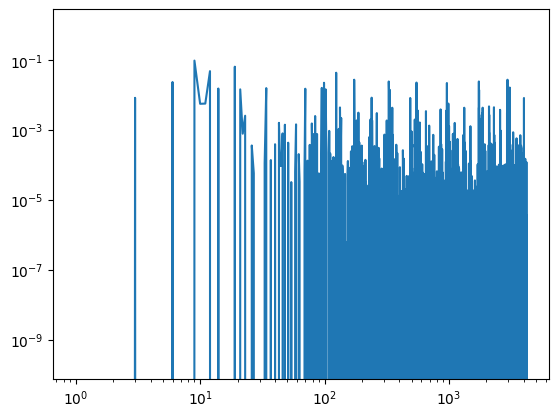

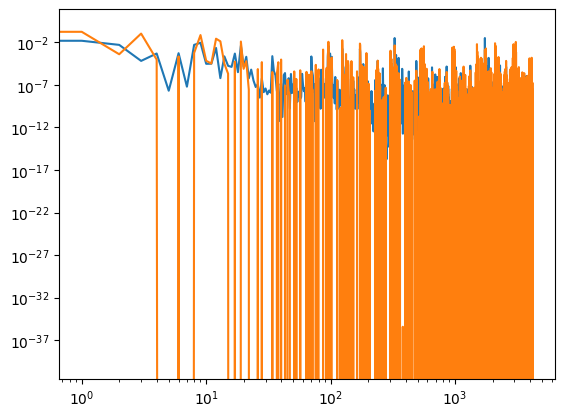

In [40]:
probb = (np.conjugate(m.forward(m.weights)) * m.forward(m.weights)).real

print(probb)
print(m.weights)
plt.plot(m.forward(m.weights))
plt.loglog()
plt.show()
prob_samples=np.average((np.conjugate(m.psi_batches) * m.psi_batches),axis=0).real

plt.plot(probb)
plt.plot(prob_samples)
plt.loglog()
plt.show()

In [ ]:
plt.figure(figsize=(30,6))

plt.bar(np.arange(psi0.shape[0]),(np.conjugate(psi0) * psi0).real)

plt.bar(np.arange(m.psi.shape[0]),probb,alpha=0.5)

#plt.bar(np.arange(m.psi.shape[0]),prob_samples,alpha=0.5)

print(m.weights)

In [44]:
fidelities=np.conjugate(np.einsum('ai,i->a',m.psi_batches,psi0))*np.einsum('ai,i->a',m.psi_batches,psi0)
print(np.average(fidelities))
for i in range(71,100):
    print(m.psi_batches[i].dot(NSMHamiltonian.hamiltonian.dot(m.psi_batches[i])))
    fidelities=np.conjugate(np.einsum('i,i->',m.psi_batches[i],psi0))*np.einsum('i,i->',m.psi_batches[i],psi0)
    print(np.average(fidelities))


0.6590436331920853
-83.77978617021112
0.61241532477421
-84.01814814980392
0.6940596743214509
-83.61441873810227
0.6247265416905062
-83.86042296722941
0.6574647290278438
-84.10039236252508
0.6952012619142164
-83.43922760444154
0.612980943089052
-84.13734024989604
0.6952356651663931
-83.78969646662442
0.6477894561704641
-84.1741234854913
0.6810493145267208
-84.08136307363867
0.6850179369802516
-83.9270719921826
0.6769567854401015
-84.05325115017419
0.6573354094568116
-83.82040991601912
0.6032344249477594
-83.83143177895047
0.6829969498701719
-84.19258276631808
0.6666826968187469
-83.94286108981305
0.6975310119768756
-84.03635545331858
0.6690711102249131
-84.06076627331913
0.6750984585997967
-84.02468190565979
0.6572055076373848
-84.14487320822543
0.6745453197869334
-84.06442026756685
0.6680024025600679
-84.11336737756787
0.6978848243664314
-84.03182260211702
0.670416921535813
-84.05146454301044
0.7087194573342607
-83.95546677691172
0.6765631354546476
-84.01485434194436
0.6772386701454738